# Проект `Movie by frame`

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import zipfile
import os
import re
import shutil
import random
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pathlib

from sklearn.metrics import accuracy_score
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Функция фиксирует seed для корректного сравнения оптимизаторов
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(13)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [ ]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lolbl4 (lolbl4-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Подготовка данных

Изначально мы имеем `3 архива` (3 подготовленных датасета), которые надо распаковать. Полученные данные следует разделить на тренировочную и валидационную выборку для дальнейших действий

In [ ]:
def process_archives(zip_dir):
    zip_dir = Path(zip_dir)
    for zip_path in zip_dir.glob("movies*.zip"):
        dataset_name = zip_path.stem
        unpack_dir = Path("/content") / dataset_name
        split_dir = Path("/content") / f"{dataset_name}_split"

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(unpack_dir)

        split_dir.mkdir(exist_ok=True, parents=True)
        for movie in unpack_dir.iterdir():
            for i, file in enumerate(sorted(movie.iterdir())):
                new_name = f"{i + 1:04d}{file.suffix}"
                file.rename(movie / new_name)

            frames = sorted(movie.iterdir())
            labels = [movie.name] * len(frames)
            X_train, X_val, y_train, y_val = train_test_split(frames, labels, test_size=0.2,
                                                            stratify=labels, random_state=0)

            for files, label_group, subset in [(X_train, y_train, "train"), (X_val, y_val, "val")]:
                target_dir = split_dir / subset / movie.name
                target_dir.mkdir(parents=True, exist_ok=True)
                for file, label in zip(files, label_group):
                    shutil.move(str(file), target_dir / file.name)

        shutil.rmtree(unpack_dir)


zip_dir = "/content/drive/MyDrive/datasets"
process_archives(zip_dir)

После того, как исходные датасеты были разделены на `train` и `val`, посмотрим, что там вообще лежит

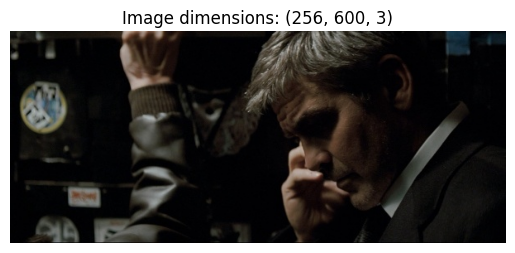

In [ ]:
def show_random_image(split_dir):
    val_path = Path(split_dir) / "val"
    random_movie = random.choice([d for d in val_path.iterdir() if d.is_dir()])
    random_frame = random.choice(list(random_movie.iterdir()))

    img = mpimg.imread(random_frame)
    plt.title(f"Image dimensions: {img.shape}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()


show_random_image("/content/movies_all_processed_split")

## Подготовка датасета и даталоадеров

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
def load_datasets(root_dir, batch_size=64):
    datasets, dataloaders = {}, {}
    for split_dir in sorted(Path(root_dir).glob("movies*_split")):
        datasets[split_dir], dataloaders[split_dir] = {}, {}

        for subset, transform in [("train", train_transform), ("val", val_transform)]:
            dataset = ImageFolder(split_dir / subset, transform=transform)
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=(subset == "train"))

            datasets[split_dir][subset] = dataset
            dataloaders[split_dir][subset] = dataloader

    return datasets, dataloaders

datasets, dataloaders = load_datasets("/content")
next(iter(datasets.values()))["val"].class_to_idx

{'1917 (2019)': 0,
 'An Education (2009)': 1,
 'Baby Driver (2017)': 2,
 'Before Midnight (2013)': 3,
 'Before Sunrise (1995)': 4,
 'Before Sunset (2004)': 5,
 'Blade Runner 2049 (2017)': 6,
 'Braveheart (1995)': 7,
 'Cruella (2021)': 8,
 'Doctor Strange (2016)': 9,
 'Doctor Strange In The Multiverse Of Madness (2022)': 10,
 'Dunkirk (2017)': 11,
 'Eyes Wide Shut (1999)': 12,
 'Fear And Loathing In Las Vegas (1998)': 13,
 'Fences (2016)': 14,
 'First Man (2018)': 15,
 'Friday (1995)': 16,
 'Good Time (2017)': 17,
 'Good Will Hunting (1997)': 18,
 'Heat (1995)': 19,
 'Hot Fuzz (2007)': 20,
 'John Wick (2014)': 21,
 'Kingdom Of Heaven (2005)': 22,
 'Lucky Number Slevin (2006)': 23,
 'Man On The Moon (1999)': 24,
 'Man of Steel (2013)': 25,
 'Match Point (2005)': 26,
 'Michael Clayton (2007)': 27,
 'Midnight In Paris (2011)': 28,
 'No Time To Die (2021)': 29,
 'Platoon (1986)': 30,
 'Pleasantville (1998)': 31,
 'Point Break (1991)': 32,
 'Rocketman (2019)': 33,
 'Skyfall (2012)': 34,
 'Sl

## Обучение CNN

In [ ]:
%pip install pytorch-lightning

In [ ]:
import pytorch_lightning as pl

class CNNClassifier(pl.LightningModule):
    def __init__(self, model_name, num_classes, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = self._get_model(model_name, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr

    def _get_model(self, model_name, num_classes):
        if model_name == "resnet50":
            model = models.resnet50(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_name == "mobilenetv2":
            model = models.mobilenet_v2(pretrained=True)
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        elif model_name == "densenet121":
            model = models.densenet121(pretrained=True)
            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        return model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        self.log("train_loss", loss, prog_bar=True, on_epoch=True, logger=True)
        self.log("train_acc", acc, prog_bar=True, on_epoch=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        self.log("val_loss", loss, prog_bar=True, on_epoch=True, logger=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True, logger=True)

        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return [optimizer], [scheduler]


In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint


def train_cnn(model_arch, data_path, epochs=10):
    seed_everything(13)

    train_loader, val_loader = dataloaders[data_path]["train"], dataloaders[data_path]["val"]
    num_classes = len(datasets[data_path]["val"].classes)

    run_name = f"{model_arch}-{Path(data_path).stem.replace('_split', '')}".replace("_", "-")
    logger = WandbLogger(project="movie-by-frame", name=run_name, log_model='all')

    model = CNNClassifier(model_name=model_arch, num_classes=num_classes)
    checkpoint = ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1,
                                 filename=f"{run_name}-best", save_last=True)

    trainer = pl.Trainer(max_epochs=epochs, accelerator=device, logger=logger, callbacks=[checkpoint],
                         enable_model_summary=False, log_every_n_steps=15)
    trainer.fit(model, train_loader, val_loader)

    best_model = CNNClassifier.load_from_checkpoint(checkpoint.best_model_path)
    torch.save(best_model.state_dict(), f"/content/drive/MyDrive/weights/{run_name}-best-weights.pt")

    print(trainer.validate(best_model, val_loader))
    wandb.finish()


### ResNet50

In [ ]:
it = iter(dataloaders.keys())

In [ ]:
train_cnn("resnet50", next(it))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8674304485321045     │
│         val_loss          │    0.47470104694366455    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.47470104694366455, 'val_acc': 0.8674304485321045}]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
train_acc_epoch,▁▅▆▆▇█████
train_acc_step,▁▂▂▄▅▅▆▇▆▇▇▇▇▆▆▇▇▇▇▆▇███▅▇██████▆█▇█▇███
train_loss_epoch,█▄▃▂▂▁▁▁▁▁
train_loss_step,█▆▄▄▄▃▂▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▃▅▄▆██▇▇██
val_loss,█▅▄▅▃▁▁▂▁▁▁
epoch,10
train_acc_epoch,0.93577
train_acc_step,0.96875


In [ ]:
train_cnn("resnet50", next(it))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9090909361839294     │
│         val_loss          │    0.2850687801837921     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2850687801837921, 'val_acc': 0.9090909361839294}]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
train_acc_epoch,▁▆▇▇██████
train_acc_step,▁▅▇▇███▇██
train_loss_epoch,█▄▂▂▁▁▁▁▁▁
train_loss_step,█▅▂▂▂▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
val_acc,▁▅▇▇▇██████
val_loss,█▄▃▃▂▁▁▁▂▁▁
epoch,10
train_acc_epoch,0.97517
train_acc_step,0.96875


In [ ]:
train_cnn("resnet50", next(it))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/movie-by-frame/c4kb74hx/checkpoints/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/movie-by-frame/c4kb74hx/checkpoints/last.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.805533230304718     │
│         val_loss          │    0.7261839509010315     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7261839509010315, 'val_acc': 0.805533230304718}]


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
train_acc_epoch,▁▄▅▆▆▇████
train_acc_step,▁▁▃▄▄▄▅▅▆▇▅▆▅▆▆▇▆▆▅▆▇▆█▇▇▇▇█▇▇██▇▇█▇█▇██
train_loss_epoch,█▄▃▃▂▂▁▁▁▁
train_loss_step,██▆▆▅▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
val_acc,▁▄▄▆▇▇█████
val_loss,█▅▄▃▂▁▁▁▁▁▁
epoch,10
train_acc_epoch,0.86142
train_acc_step,0.875


### MobileNetV2

In [ ]:
it = iter(dataloaders.keys())

In [ ]:
train_cnn("mobilenetv2", next(it))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 196MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8183305859565735     │
│         val_loss          │     0.639574408531189     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.639574408531189, 'val_acc': 0.8183305859565735}]


epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
train_acc_epoch,▁▄▅▆▇▇████
train_acc_step,▁▂▂▃▅▅▅▅▄▅▅▆▇▆▆▇▇█▇▇▇▇█▇▇█▇▇▇▇▇▇█▇██▇▇▇▇
train_loss_epoch,█▅▃▃▂▂▁▁▁▁
train_loss_step,█▅▅▄▃▃▃▃▃▂▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▂▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇█████
val_acc,▁▄▆▆▇▇█████
val_loss,█▅▃▃▂▂▁▁▁▁▁
epoch,10
train_acc_epoch,0.84612
train_acc_step,0.8125


In [ ]:
train_cnn("mobilenetv2", next(it))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9130434989929199     │
│         val_loss          │    0.33323732018470764    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.33323732018470764, 'val_acc': 0.9130434989929199}]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
train_acc_epoch,▁▅▆▇▇█████
train_acc_step,▁▄▄▃▅▆▇█▇▇
train_loss_epoch,█▅▃▂▂▁▁▁▁▁
train_loss_step,█▅▄▄▂▂▂▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
val_acc,▁▅▆▇▆▇█████
val_loss,█▄▃▂▂▁▂▁▁▁▁
epoch,10
train_acc_epoch,0.94439
train_acc_step,0.96875


### DenseNet121

In [ ]:
it = iter(dataloaders.keys())

In [ ]:
train_cnn("densenet121", next(it))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 193MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8392798900604248     │
│         val_loss          │    0.5700963735580444     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5700963735580444, 'val_acc': 0.8392798900604248}]


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
train_acc_epoch,▁▄▅▆▇▇████
train_acc_step,▁▂▁▂▂▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▆█▇▇▇▇▇███▇██████
train_loss_epoch,█▅▃▃▂▂▁▁▁▁
train_loss_step,█▇▇▇▆▄▄▄▄▃▂▂▃▃▂▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
val_acc,▁▅▆▆▇▇█▇███
val_loss,█▅▃▃▂▁▁▁▁▁▁
epoch,10
train_acc_epoch,0.9025
train_acc_step,0.92188


In [ ]:
train_cnn("densenet121", next(it))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9090909361839294     │
│         val_loss          │    0.32991698384284973    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.32991698384284973, 'val_acc': 0.9090909361839294}]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
train_acc_epoch,▁▅▆▇▇█████
train_acc_step,▁▅▅▆▇█▇▇▇█
train_loss_epoch,█▅▃▂▂▁▁▁▁▁
train_loss_step,█▅▄▃▂▁▂▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
val_acc,▁▄▇▇▇██████
val_loss,█▅▃▂▁▁▁▁▁▁▁
epoch,10
train_acc_epoch,0.97219
train_acc_step,0.98438


## Выводы и таблица с метриками

| Модели               | 5 фильмов   | 50 фильмов  | 250+ фильмов |
|----------------------|-------------|-------------|--------------|
| resnet50             | `0.9091`    | `0.8674`    | `0.8055`     |
| mobilenetv2          | `0.9130`    | `0.8183`    | -            |
| densenet121          | `0.9091`    | `0.8398`    | -            |

Как можно заметить, качество на CNN с увеличением числа классов падает, причём заметно => при обучении на 250+ фильмов это качество станет ещё хуже, так как моделям CNN становится всё тяжелее и тяжелее запоминать паттерны среди большого числа фильмов и кадров.

Все графики по [ссылке](https://wandb.ai/lolbl4-hse/movie-by-frame/table?nw=nwuserlolbl4)
